In [1]:
import optuna
import plotly
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# from optuna.visualization import plot_contour
# from optuna.visualization import plot_edf
# from optuna.visualization import plot_intermediate_values
# from optuna.visualization import plot_optimization_history
# from optuna.visualization import plot_parallel_coordinate
# from optuna.visualization import plot_param_importances
# from optuna.visualization import plot_slice
print(plotly.__version__)  

5.18.0


In [25]:
study_names = ["1511_fp_uc_CodeBERT_f1_default_max_evals150", "1511_fp_uc_CodeBERT_f1_equalize_max_evals150", "1511_fp_uc_CodeBERT_f1_descendants_max_evals150", "1511_fp_uc_CodeBERT_f1_reachable_leaf_nodes_max_evals150", "1511_fp_uc_CodeBERT_f1_CE_max_evals150","1511_fp_uc_CodeBERT_f1_FL_max_evals150"]
# study_names = ["1511_fp_uc_CodeBERT_f1_default_max_evals150"]
studies = []

for study_name in study_names:
    db_url = f"sqlite:///database/{study_name}.db"
    study = optuna.load_study(study_name=study_name, storage=db_url)
    studies.append(study)

/tmp/ipykernel_134337/2273685101.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


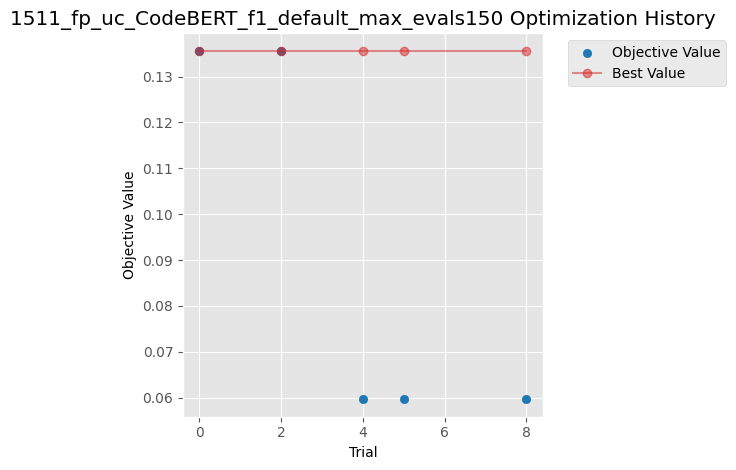

/tmp/ipykernel_134337/2273685101.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


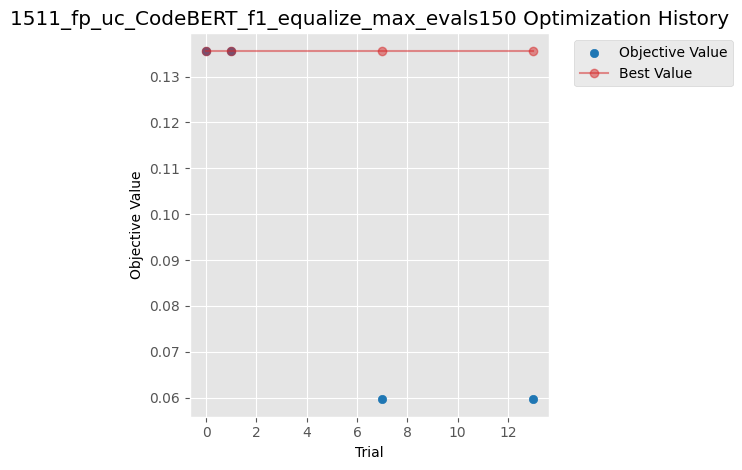

/tmp/ipykernel_134337/2273685101.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


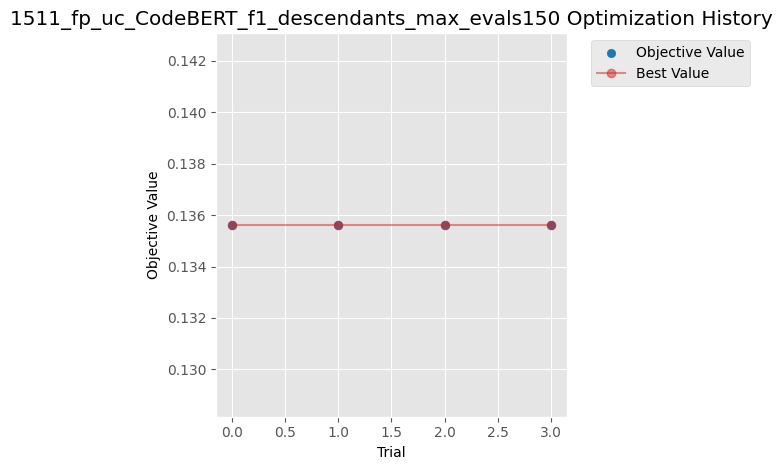

/tmp/ipykernel_134337/2273685101.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


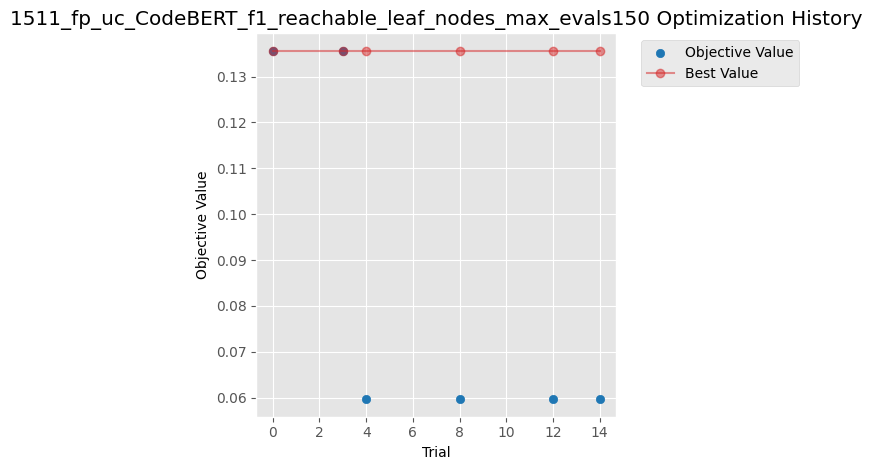

/tmp/ipykernel_134337/2273685101.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


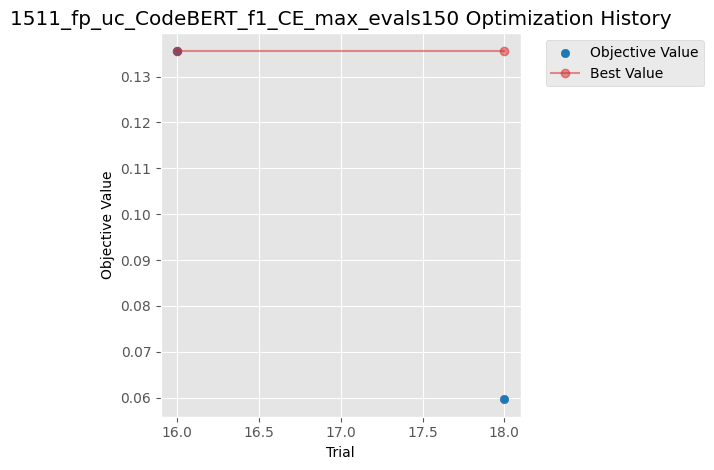

/tmp/ipykernel_134337/2273685101.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


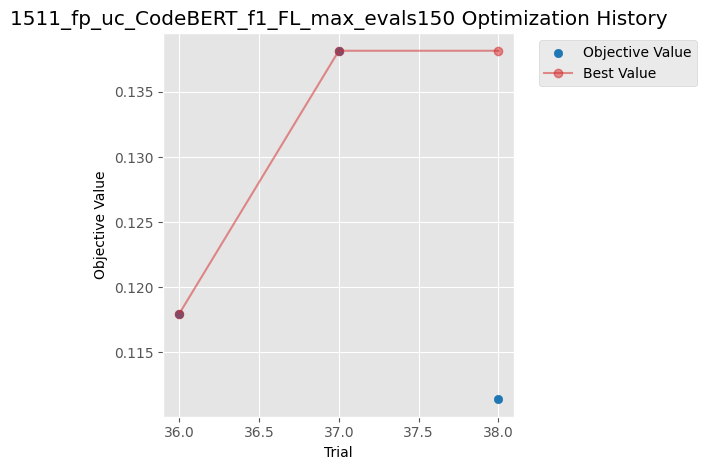

In [26]:
for i, study in enumerate(studies):
    optuna.visualization.matplotlib.plot_optimization_history(study)
    plt.tight_layout()
    plt.title(f"{study_names[i]} Optimization History")
    plt.show()

In [27]:
optuna.importance.get_param_importances(studies[0])

OrderedDict([('per_device_train_batch_size', 0.45968485413799764),
             ('classifier_factor', 0.27633504492915895),
             ('learning_rate', 0.1915629899397098),
             ('weight_decay', 0.07241711099313362)])

In [28]:
# dir(studies[0].trials[0])
studies[0].trials[0]._trial_id

1

In [24]:
data = []
for trial in studies[1].trials:
    # Only completed trials will be considered
    if trial.state == optuna.trial.TrialState.COMPLETE:
        row = trial.params  # Hyperparameters
        row["objective_value"] = trial.value  # Performance value
        row["trial_id"] = trial._trial_id
        data.append(row)

# Convert the data to a Pandas DataFrame
df2 = pd.DataFrame(data)
df2.isna().sum()

IndexError: list index out of range

In [ ]:
data = []
for trial in studies[2].trials:
    # Only completed trials will be considered
    if trial.state == optuna.trial.TrialState.COMPLETE:
        row = trial.params  # Hyperparameters
        row["objective_value"] = trial.value  # Performance value
        data.append(row)

# Convert the data to a Pandas DataFrame
df3 = pd.DataFrame(data)
df3.isna().sum()

In [ ]:
data = []
for trial in studies[3].trials:
    # Only completed trials will be considered
    if trial.state == optuna.trial.TrialState.COMPLETE:
        row = trial.params  # Hyperparameters
        row["objective_value"] = trial.value  # Performance value
        data.append(row)

# Convert the data to a Pandas DataFrame
df4 = pd.DataFrame(data)
df4.isna().sum()

In [ ]:
for i, study in enumerate(studies):
    optuna.visualization.matplotlib.plot_param_importances(study)
    plt.tight_layout()
    plt.title(f"{study_names[i]} Param Importance")
    plt.show()

# optuna.visualization.matplotlib.plot_param_importances(study)
# plt.show()

# sns.set_theme()
# sns.set_style("whitegrid")
# x = optuna.visualization.matplotlib.plot_param_importances(study_eqaulize)

# plt.tight_layout()
# plt.savefig('hpo_importance.png')
# plt.show()

In [ ]:
# Slice Plot

for i, study in enumerate(studies):
    optuna.visualization.matplotlib.plot_slice(study)
    plt.tight_layout()
    plt.title(f"{study_names[i]} Slice Plot")
    plt.show()

# optuna.visualization.matplotlib.plot_slice(study)
# plt.show()

In [ ]:
n_best_trials = 3  # Number of best trials to show

# Get all the trials sorted by their completed values
all_trials = study.trials_dataframe()
sorted_trials = all_trials.sort_values("value", ascending=study.direction == "maximize")

# Print the best n trials
print(f"Top {n_best_trials} Trials:")
print(sorted_trials.head(n_best_trials))

In [ ]:
import matplotlib.pyplot as plt

def plot_optimization_histories(studies, study_names):
    plt.figure(figsize=(10, 6))

    for study, name in zip(studies, study_names):
        trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])
        best_values = [float('inf')] * len(trials)
        for i, trial in enumerate(sorted(trials, key=lambda x: x.number)):
            if i > 0:
                best_values[i] = min(best_values[i - 1], trial.value)
            else:
                best_values[i] = trial.value
        
        plt.plot(best_values, label=name)

    plt.title("Optimization Histories Comparison")
    plt.xlabel("Number of Trials")
    plt.ylabel("Best Objective Value")
    plt.legend()
    plt.grid()
    plt.show()

plot_optimization_histories(studies, study_names)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

def plot_values_over_time(studies, study_names):
    plt.figure(figsize=(12, 6))
    
    for study, name in zip(studies, study_names):
        trial_timestamps = [datetime.fromtimestamp(trial.datetime_start.timestamp()) for trial in study.trials]
        trial_values = [trial.value for trial in study.trials]

        plt.plot(trial_timestamps, trial_values, marker='o', label=name)

    # Formatting the plot
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate()  # Rotation

    plt.title("Objective Values Over Time Across Studies")
    plt.xlabel("Time")
    plt.ylabel("Objective Value")
    plt.legend()
    plt.grid()
    plt.show()

plot_values_over_time(studies, study_names)
# don't smoothing

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime

def smooth_values(values, window_size):
    """Apply a simple moving average smoothing."""
    return pd.Series(values).rolling(window=window_size, min_periods=1).mean().tolist()

def plot_values_over_time_with_smoothing(studies, study_names, window_size=3):
    plt.figure(figsize=(12, 6))
    
    for study, name in zip(studies, study_names):
        trial_timestamps = [datetime.fromtimestamp(trial.datetime_start.timestamp()) for trial in study.trials]
        trial_values = [trial.value for trial in study.trials]
        
        # Apply smoothing
        smoothed_values = smooth_values(trial_values, window_size)

        plt.plot(trial_timestamps, smoothed_values, marker='o', label=name)

    # Formatting the plot
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate()  # Rotation

    plt.title(f"Smoothed Objective Values Over Time Across Studies (Window size: {window_size})")
    plt.xlabel("Time")
    plt.ylabel("Smoothed Objective Value")
    plt.legend()
    plt.grid()
    plt.show()

plot_values_over_time_with_smoothing(studies, study_names,window_size=50)


In [ ]:
plot_values_over_time_with_smoothing(studies, study_names,window_size=100)